In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os



In [2]:
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Adjust based on VGG16 input size
BATCH_SIZE = 32

# Augment data to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1.0/255,   # Normalize images
    rotation_range=20,  # Rotate images up to 20 degrees
    zoom_range=0.2,     # Random zoom
    shear_range=0.2,    # Shear transformation
    horizontal_flip=True,
    validation_split=0.1  # Use 10% of train data for validation
)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 4482 images belonging to 10 classes.
Found 495 images belonging to 10 classes.


In [3]:
def create_model():
    base_model = VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),  # Dropout to prevent overfitting
        Dense(10, activation='softmax')  # 10 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()


58889256/58889256 [==============================] - 24s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
141/141 [==============================] - 412s 3s/step - loss: 1.5754 - accuracy: 0.5136 - val_loss: 0.8289 - val_accuracy: 0.7798 - lr: 1.0000e-04
Epoch 2/20
141/141 [==============================] - 424s 3s/step - loss: 0.6457 - accuracy: 0.7903 - val_loss: 0.4230 - val_accuracy: 0.8788 - lr: 1.0000e-04
Epoch 3/20
141/141 [==============================] - 422s 3s/step - loss: 0.4298 - accuracy: 0.8648 - val_loss: 0.3673 - val_accuracy: 0.8768 - lr: 1.0000e-04
Epoch 4/20
141/141 [==============================] - 420s 3s/step - loss: 0.3676 - accuracy: 0.8817 - val_loss: 0.2723 - val_accuracy: 0.9253 - lr: 1.0000e-04
Epoch 5/20
141/141 [==============================] - 423s 3s/step - loss: 0.3020 - accuracy: 0.9052 - val_loss: 0.2166 - val_accuracy: 0.9434 - lr: 1.0000e-04
Epoch 6/20
141/141 [==============================] - 422s 3s/step - loss: 0.2469 - accuracy: 0.9286 - val_loss: 0.1759 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 7/20
141/141 [====================

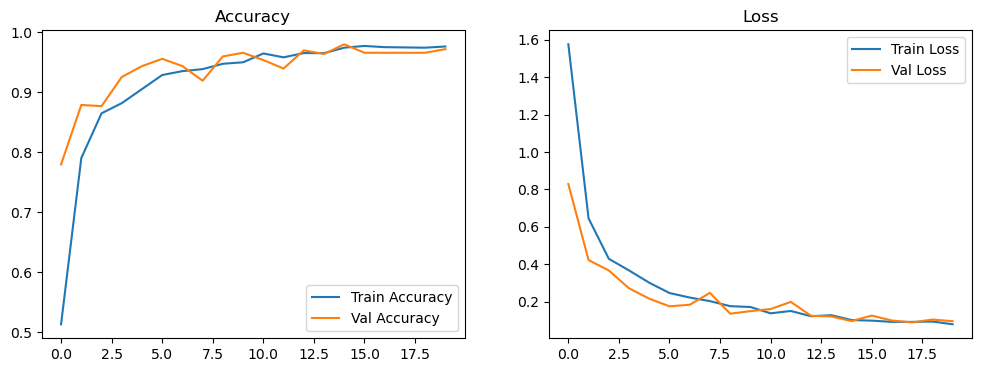

In [5]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_history(history)


In [16]:
train_path = './dataset/train/'
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


Found 4482 images belonging to 10 classes.


In [18]:
import os
print(os.listdir(train_path))  # Should print ['c0', 'c1', 'c2', ..., 'c9']


['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [19]:
val_generator = train_datagen.flow_from_directory(
    './dataset/train/',  # Same path, but for validation subset
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 495 images belonging to 10 classes.


In [20]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './dataset/train/', target_size=(224, 224), batch_size=2, class_mode='categorical'
)
img, label = next(test_gen)
print(f"Image shape: {img.shape}, Label: {label}")



Found 4977 images belonging to 10 classes.
Image shape: (2, 224, 224, 3), Label: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [22]:
model.save('driver_distraction_model.h5')


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image


In [4]:
model = tf.keras.models.load_model('driver_distraction_model.h5')
print("Model loaded successfully!")


NameError: name 'h5py' is not defined

In [24]:
model = tf.keras.models.load_model('driver_distraction_model.h5')
print("Model loaded successfully!")


Model loaded successfully!


In [32]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load image
    img_array = image.img_to_array(img) / 255.0  # Convert to array and normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


1/1 [==============================] - 0s 137ms/step


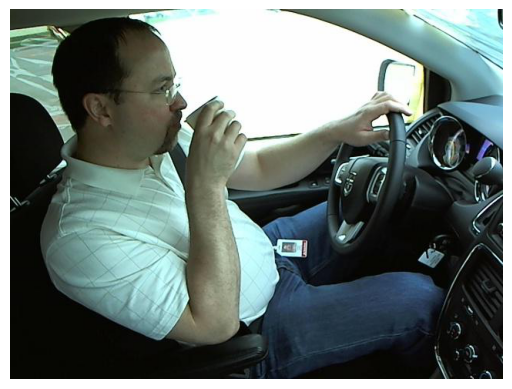

Predicted Class: Drinking


In [56]:
# Path to the image
img_path = r"C:\Users\VICTUS\OneDrive\ドキュメント\Data Science\DL Project\prediction\dataset\test\img_778.jpg"


# Preprocess the image
img_array = preprocess_image(img_path)

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Class labels
class_labels = [
    "Safe", "Texting (Right)", "Phone (Right)", "Texting (Left)", "Phone (Left)",
    "Radio", "Drinking", "Reach Behind", "Hair & Makeup", "Talking"
]

# Display the image
plt.imshow(image.load_img(img_path))
plt.axis('off')  # Hide axes
plt.show()

# Output the prediction
print(f"Predicted Class: {class_labels[predicted_class]}")
